# My questions for Rob:
- Which projection do I want?
- How can I apply cartopy to my maps?
- How do I get the actual latitudes in my latitudinal transects?

## Which projection do I want?
https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

I want a prjection that shows the Nordic Seas, SPG and STG. 

<span style="color:red">By now a simple PlateCarree projection would already be enough</span>

## How can I apply cartopy to my maps?

In [56]:
import os                  

import numpy as np
import xarray as xr
import pop_tools

import matplotlib
import cartopy
import cmocean.cm as cmo

plt = matplotlib.pyplot
ticker = matplotlib.ticker
ccrs = cartopy.crs

In [7]:
# load mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

# load file
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_temp = xr.open_dataset(temp_file).isel(time=0).where(mask3d == 1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
field = ds_temp.TEMP.isel(z_t=0)
#field = ds_temp.TEMP.isel(z_t=0).roll(nlon=-100)

# arguments
vmin = -abs(field).max()
vmax = abs(field).max()
extent_1 = (difference_temp.TLONG.min(), difference_temp.TLONG.max(), difference_temp.TLAT.min(), difference_temp.TLAT.max())
extent_2 = [-35, 40, 45, 90]
cmap = cmo.balance
cmap.set_bad('gray')

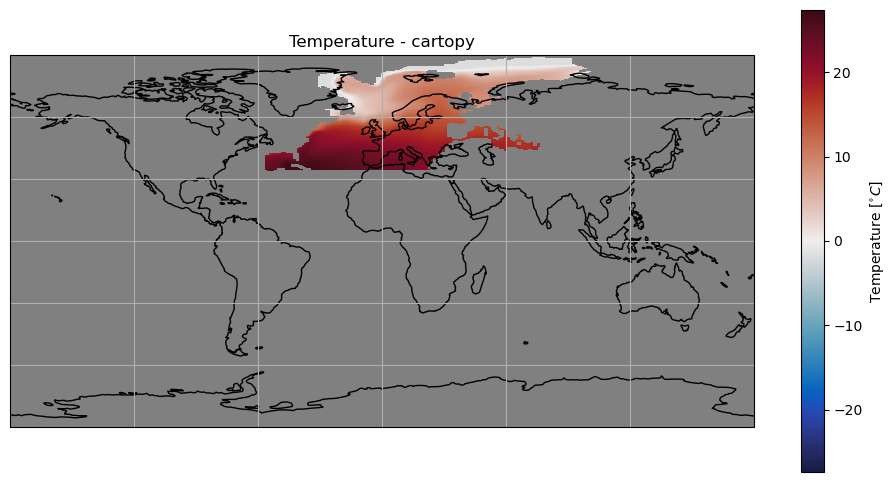

In [37]:
# plot
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=extent_1,
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
#cs = ax.imshow(field, origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)

#ax.set_extent(extent_2)
ax.coastlines()
cbar = plt.colorbar(cs, label=r'Temperature [$^{\circ}C$]')
plt.title('Temperature - cartopy')

plt.show()

### Helene's approach

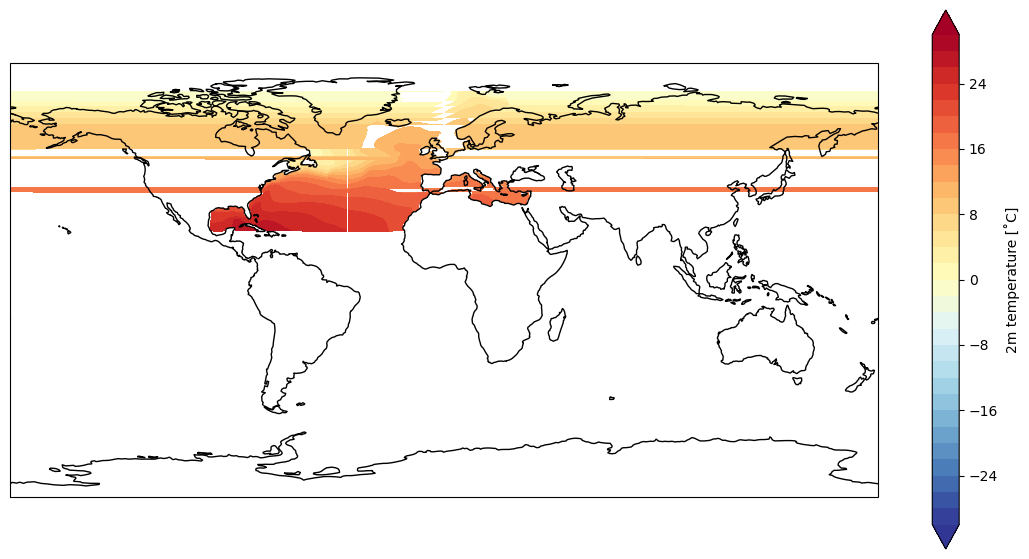

In [46]:
# We will use the cartopy package
from cartopy import crs
import cartopy.feature as cfeatures

lon = ds_temp['TLONG']
lat = ds_temp['TLAT']
temp_plot = field

# plotting
data_proj = crs.PlateCarree( )  # Projection our data is in: data is in lon lat coordinate system
display_proj = crs.PlateCarree( ) # Projection we want to display in

fig=plt.figure(figsize = (14,7))
ax = plt.axes( projection = display_proj )  
ctrs = plt.contourf(lon,lat,temp_plot, transform = data_proj ,cmap='RdYlBu_r',
                    levels = np.linspace(-30,30,31),extend='both') #extend='both' colors values outside range in levels
ax.coastlines( )
cbar = plt.colorbar(ctrs, label='2m temperature [˚C]')

### BSF approach

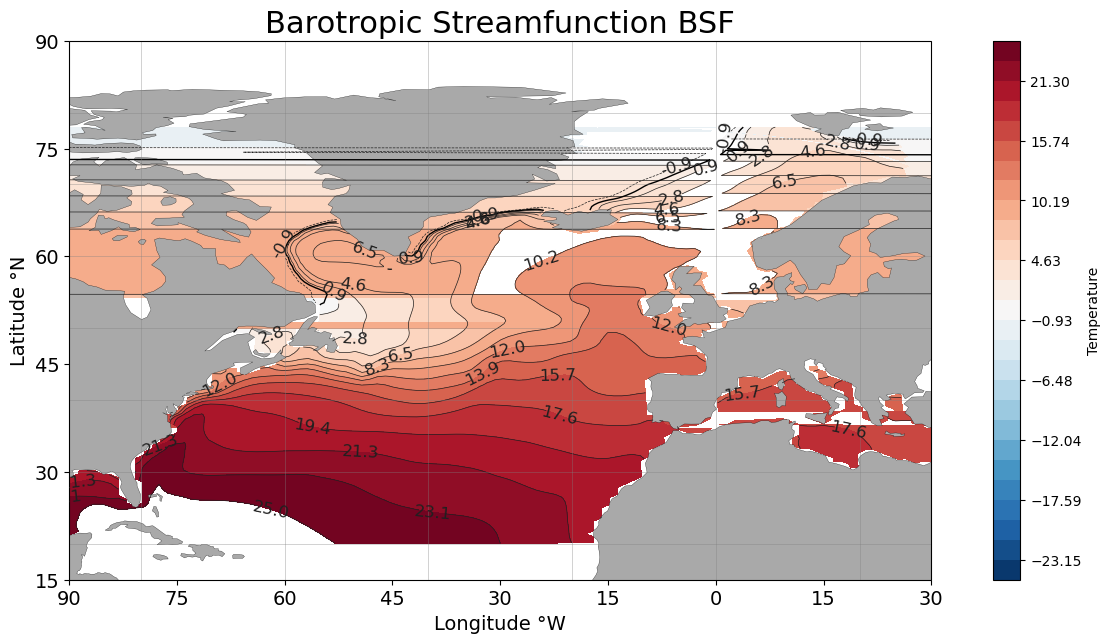

In [66]:
# set kwargs
crs = cartopy.crs.PlateCarree()
vmin = -25
vmax = 25
levels = np.linspace(vmin, vmax, 28)
#cmap = cmo.balance
cmap = 'RdBu_r'
extent = [-78, 20, 20, 80]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',linewidth=0.2, edgecolor='black', facecolor='darkgray')
title = 'Barotropic Streamfunction BSF'

fig = plt.figure(figsize=(16, 7))
ax = plt.axes(projection=crs)
land = ax.add_feature(nature_coast)

ax.set_extent(extent)
ax.set_title(title, fontsize=22)
cf = ax.contourf(ds_temp.TLONG.roll(nlon=-80), ds_temp.TLAT.roll(nlon=-80), ds_temp.TEMP.isel(z_t=0).roll(nlon=-80), levels=levels, cmap=cmap, norm=norm)
cf2 = ax.contour(ds_temp.TLONG.roll(nlon=-80), ds_temp.TLAT.roll(nlon=-80), ds_temp.TEMP.isel(z_t=0).roll(nlon=-80), levels=levels, colors=['#202020', ], linewidths=0.5)
ax.clabel(cf2, inline=True, fontsize=12, fmt='%1.1f')
cf_zero_contour = ax.contour(ds_temp.TLONG.roll(nlon=-80), ds_temp.TLAT.roll(nlon=-80), ds_temp.TEMP.isel(z_t=0).roll(nlon=-80), levels=[0], colors=['black'], linewidths=1, linestyles='solid')
cbar = fig.colorbar(cf, ax=ax)
cbar.ax.set_ylabel('Temperature')

# Use MaxNLocator to set the number of ticks
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=9))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Manually set tick labels
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f'{int(abs(tick))}' for tick in xticks], fontsize=14)
ax.set_yticklabels([f'{int(tick)}' for tick in yticks], fontsize=14)
ax.set_ylabel('Latitude °N', fontsize=14)
ax.set_xlabel('Longitude °W', fontsize=14)
ax.gridlines(crs=crs, linewidth=0.5, color='gray', alpha=0.5, linestyle='-', draw_labels={'bottom': False, 'left': False, 'right': False, 'top': False})

plt.show()

### Xarray Approach

In [74]:
import cartopy.mpl.geoaxes as geoaxes

# Create a PlateCarree projection
proj = ccrs.PlateCarree()

# Create a GeoAxes using the subplot method from cartopy.mpl.geoaxes
fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(8, 6))
ax = geoaxes.GeoAxes(projection=proj)
fig.add_axes(ax)

# Plot the dataset using xarray's plot method
ds_temp.TEMP.plot(ax=ax, transform=proj, vmin=ds_temp.TEMP.min(), vmax=ds_temp.TEMP.max())

# Customize the plot as needed
plt.title('PlateCarree Projection')
plt.show()

## How do I get the actual latitudes in my latitudinal transects?

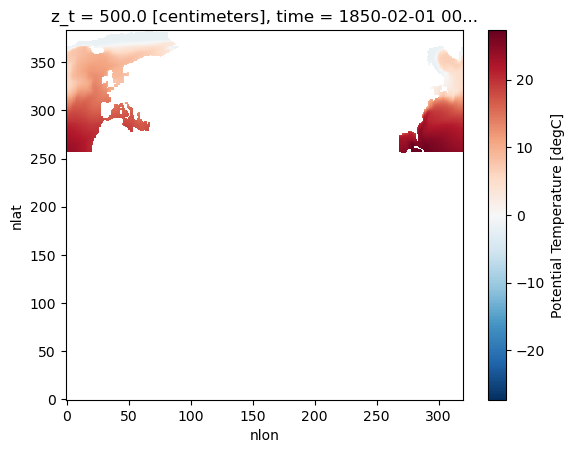

In [16]:
# check map
ds_temp.TEMP.isel(z_t=0).plot()

In [19]:
field = ds_temp.TEMP.isel(nlon=0)
cmap = cmo.balance
cmap.set_bad('gray')

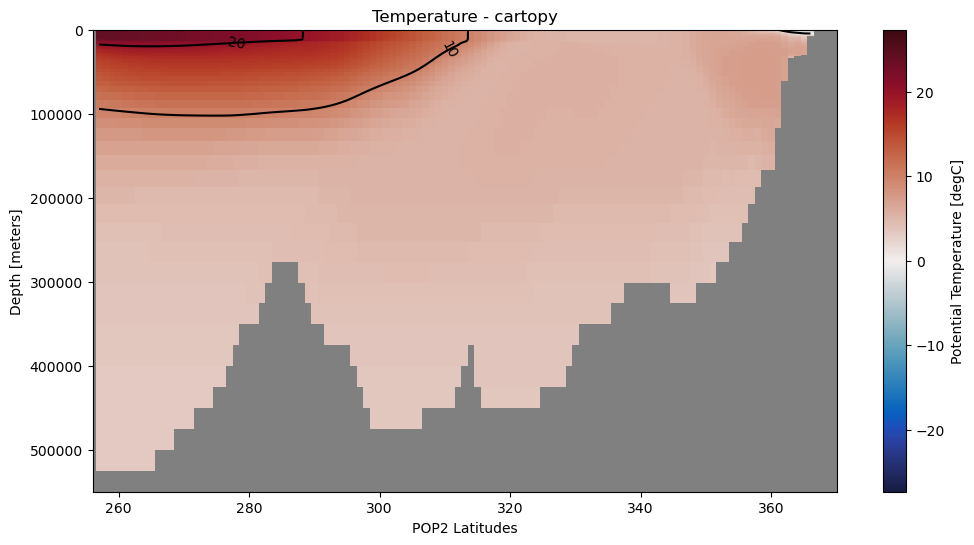

In [20]:
plt.figure(figsize=(12, 6))
lati_sigma_plot = field.plot(cmap=cmap,yincrease=False, vmin=vmin, vmax=vmax)
contour = field.plot.contour(colors='k') 
plt.clabel(contour, inline=False, fontsize=10)

plt.xlim([256, 370])
plt.ylabel('Depth [meters]')
plt.xlabel('POP2 Latitudes')
plt.title('Temperature - cartopy')

plt.gca().invert_yaxis()

plt.show()